In [ ]:
%pip install prophet
%pip install scikit-learn
%pip install seaborn
%pip install scipy
%pip install db-dtypes
%pip install -U scikit-learn
%pip install openpyxl
%pip install matplotlib

In [1]:
#importamos todas las librerías necesarias
import pandas as pd
import datetime 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import sys

from dotenv import load_dotenv
from prophet import Prophet
from datetime import date, timedelta
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.ensemble import IsolationForest

In [2]:
src_path = os.path.join(os.path.dirname(os.getcwd()), 'src/ci-345_controles-valores-de-unidad-de-fondo')
sys.path.append(src_path)

from data.make_dataset import modify_data, bq_consulta
from data.analytics import historic, rename, analisis, prueba_shapiro

/home/aescobag@PROTECCION.LOCAL/ci-345_controles-valores-de-unidad-de-fondo/venv/lib/python3.7/site-packages/google/auth/__init__.py:55: Python37DeprecationWarning: After January 1, 2024, new releases of this library will drop support for Python 3.7. More details about Python 3.7 support can be found at https://cloud.google.com/python/docs/python37-sunset/
  warnings.warn(message, Python37DeprecationWarning)
/home/aescobag@PROTECCION.LOCAL/ci-345_controles-valores-de-unidad-de-fondo/venv/lib/python3.7/site-packages/google/oauth2/__init__.py:40: Python37DeprecationWarning: After January 1, 2024, new releases of this library will drop support for Python 3.7. More details about Python 3.7 support can be found at https://cloud.google.com/python/docs/python37-sunset/
  warnings.warn(message, Python37DeprecationWarning)


In [3]:
load_dotenv()
PROJECT = os.getenv('PROJECT')
DATASET = os.getenv('DATASET')
sql_text = f"""SELECT FECHA_VALORACION,NEMOTECNICO, AVG(VALOR_UTILIDAD_PERDIDA / valor_mercado) 
FROM `{PROJECT}.{DATASET}.SQLSERVER_SPIRITDB_SPIRIT_TSPT_VALORACION_POS` WHERE VALOR_MERCADO != 0 AND NEMOTECNICO IS NOT NULL GROUP BY FECHA_VALORACION, NEMOTECNICO"""

In [4]:
dfrme = bq_consulta(sql_text)

/home/aescobag@PROTECCION.LOCAL/ci-345_controles-valores-de-unidad-de-fondo/venv/lib/python3.7/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/home/aescobag@PROTECCION.LOCAL/ci-345_controles-valores-de-unidad-de-fondo/venv/lib/python3.7/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
dfrme = dfrme[dfrme['NEMOTECNICO'] != '']

In [6]:
dfrme[dfrme['NEMOTECNICO'] == '']

,FECHA_VALORACION,NEMOTECNICO,f0_


In [7]:
original_data = {}
by_nemo = dfrme.groupby('NEMOTECNICO')

for groups, data in by_nemo:
    original_data[groups] = data
    

 Obtenemos el conjunto de datos del nemotecnico para el que se desea conocer si un dato es atipico o no y analizamos los datos

In [8]:
data = modify_data('TFIT31261050')
data.info(),data.describe()

/home/aescobag@PROTECCION.LOCAL/ci-345_controles-valores-de-unidad-de-fondo/venv/lib/python3.7/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


/home/aescobag@PROTECCION.LOCAL/ci-345_controles-valores-de-unidad-de-fondo/venv/lib/python3.7/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 4013 to 683216
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   FECHA_VALORACION  1169 non-null   datetime64[ns]
 1   NEMOTECNICO       1169 non-null   object        
 2   f0_               1169 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 36.5+ KB


(None,
                f0_
 count  1169.000000
 mean      0.000089
 std       0.010373
 min      -0.053723
 25%      -0.003021
 50%       0.000258
 75%       0.002644
 max       0.062092)

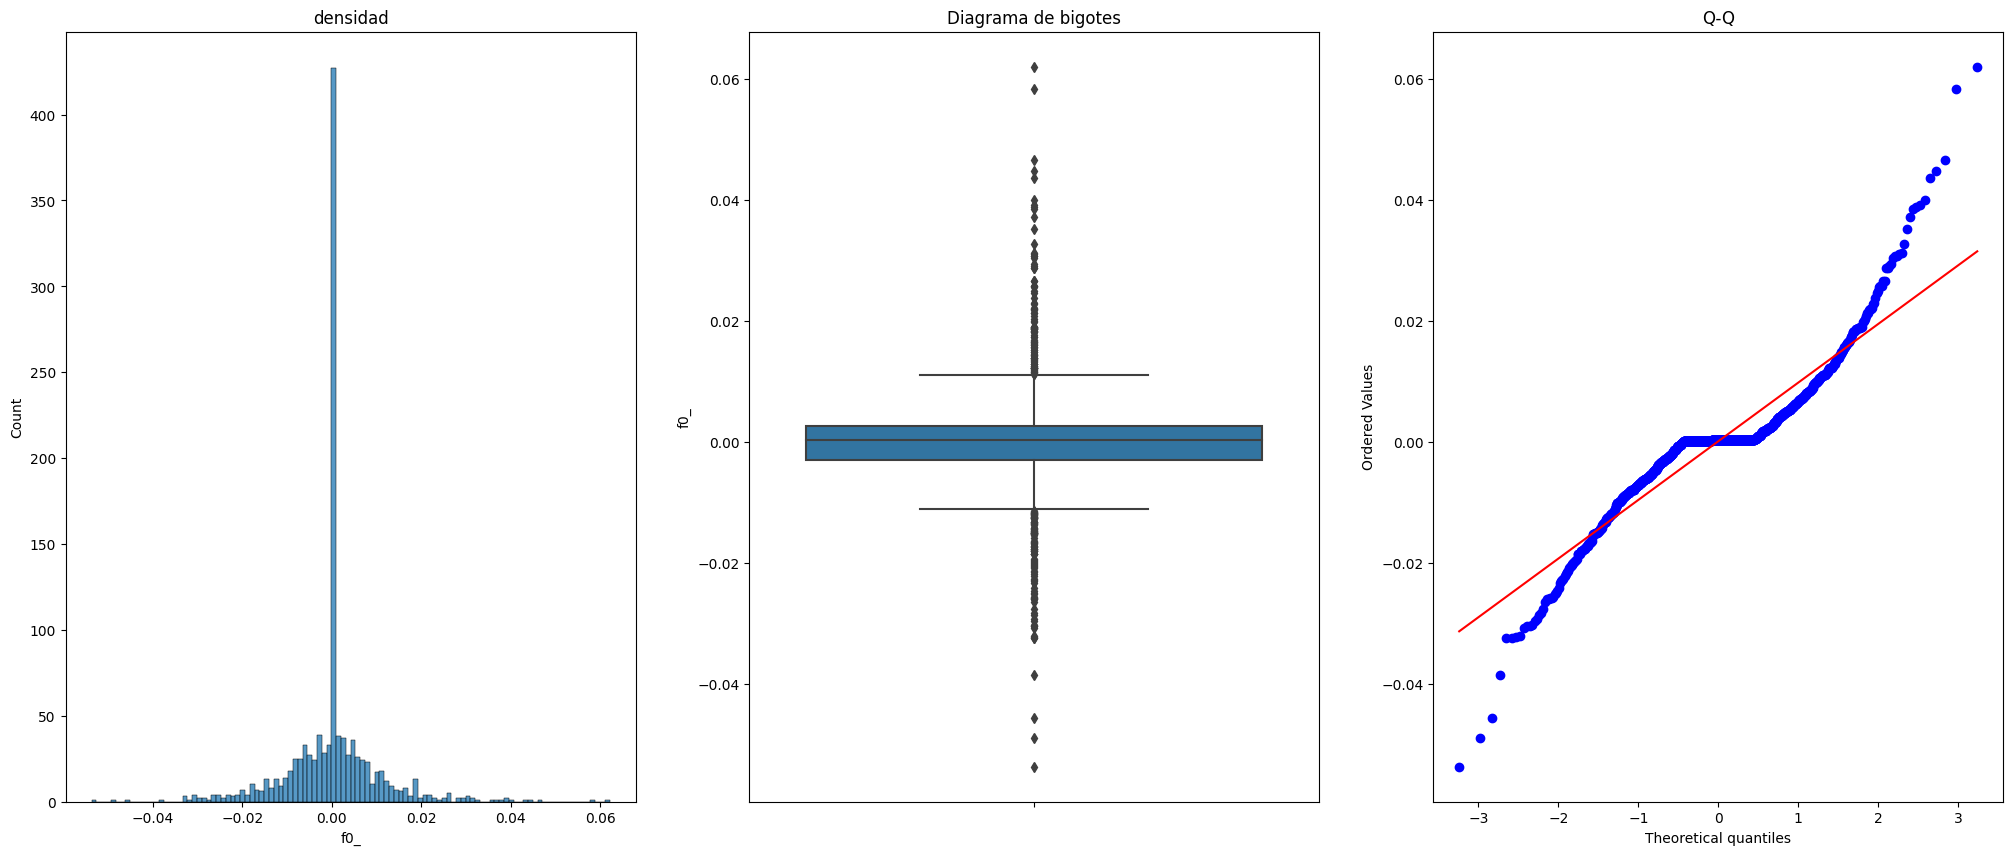

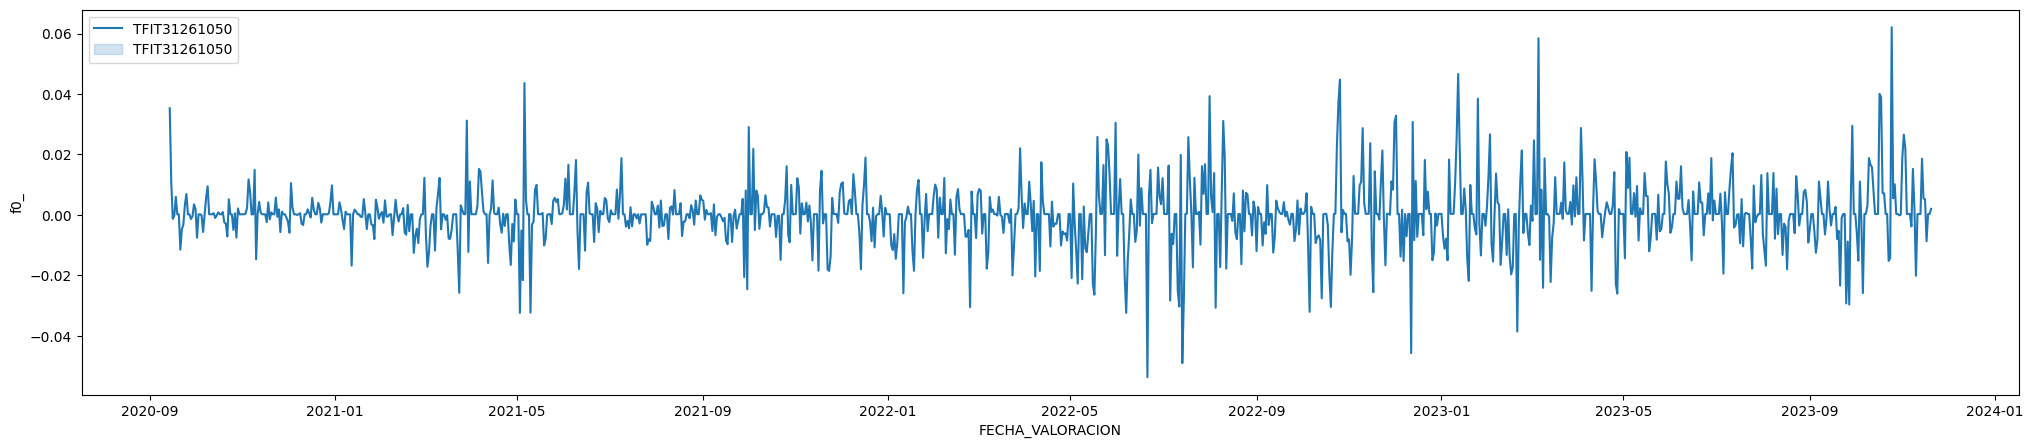

(None, None)

In [22]:
analisis(data), historic(data)

In [23]:
prueba_shapiro(data)

stat=0.87408, p=0.00000


'Los datos no parecen normales para el nemotecnico TFIT31261050 (se rechaza H0)'

Desarrollo de los modelos y seleccion

In [9]:
datos = rename(data)
datos_copy = datos.copy()
datos_copy.sort_values(by='ds')

,ds,NEMOTECNICO,y
573795,2020-09-14,TFIT31261050,0.035291
44777,2020-09-15,TFIT31261050,0.010831
234701,2020-09-16,TFIT31261050,-0.001318
649178,2020-09-17,TFIT31261050,-0.000296
12812,2020-09-18,TFIT31261050,0.005971
...,...,...,...
304994,2023-11-22,TFIT31261050,0.001964
115846,2023-11-23,TFIT31261050,-0.015870
52730,2023-11-24,TFIT31261050,-0.009732
617729,2023-11-25,TFIT31261050,0.000294


In [10]:
training = datos_copy.loc[datos_copy['ds'] < '2023-01-01']

In [11]:
test = datos_copy.loc[datos_copy['ds'] >= '2023-01-01']
test = test.loc[test['ds'] < '2023-11-21']

In [52]:
#se entrena el modelo
modelo = Prophet(interval_width=0.90)
modelo.fit(training)


13:59:44 - cmdstanpy - INFO - Chain [1] start processing


13:59:45 - cmdstanpy - INFO - Chain [1] done processing


In [53]:
with open('modelo_prophet.pkl', 'wb') as modelo_prophet_guardado:
    pickle.dump(modelo, modelo_prophet_guardado)

In [12]:
modelo_prophet_guardado= open('modelo_prophet.pkl', 'rb')
modelo_cargado_p = pickle.load(modelo_prophet_guardado)

In [13]:
future = modelo_cargado_p.make_future_dataframe(periods = 365)

forecast = modelo_cargado_p.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-09-14,-0.000711,-0.015860,0.013807
1,2020-09-15,0.000632,-0.013836,0.015795
2,2020-09-16,0.002404,-0.012345,0.018767
3,2020-09-17,0.001188,-0.014466,0.016821
4,2020-09-18,0.001710,-0.013552,0.017636
...,...,...,...,...
1199,2023-12-27,-0.000782,-0.015253,0.014359
1200,2023-12-28,-0.002196,-0.016561,0.012972
1201,2023-12-29,-0.001857,-0.017019,0.013007
1202,2023-12-30,-0.002150,-0.018233,0.014199


In [14]:
modelo_cv = cross_validation(model = modelo, initial = '365.25 days', period = '7 days', horizon = '30 days')
modelo_cv.head()

NameError: name 'modelo' is not defined

In [34]:
model_performance = performance_metrics(modelo_cv, rolling_window=1)
model_performance

,horizon,mse,rmse,mae,mdape,smape,coverage
0,30 days,0.000136,0.011668,0.007766,1.156401,1.649276,0.777604


In [15]:
resultado = pd.merge(test[['ds','y']], forecast[['ds','yhat','yhat_lower','yhat_upper']], on = 'ds' )
resultado.head()

,ds,y,yhat,yhat_lower,yhat_upper
0,2023-05-16,0.006214,-0.002438,-0.018070,0.013649
1,2023-07-16,0.000268,-0.002379,-0.017987,0.012386
2,2023-05-12,0.002188,-0.003591,-0.020458,0.012465
3,2023-05-28,0.000307,0.002574,-0.012798,0.018649
4,2023-07-09,0.000278,-0.001621,-0.014728,0.013968


In [16]:
evaluacion_pasados = pd.merge(training[['ds', 'y']],forecast[['ds','yhat_lower','yhat_upper']], on='ds', how='inner')
evaluacion_pasados

,ds,y,yhat_lower,yhat_upper
0,2021-01-14,0.001725,-0.018073,0.013588
1,2021-09-13,-0.000800,-0.016966,0.013963
2,2021-01-12,-0.016782,-0.017961,0.011607
3,2022-09-09,-0.003359,-0.015419,0.015774
4,2021-05-12,-0.002298,-0.016661,0.014843
...,...,...,...,...
834,2020-12-02,-0.005886,-0.013305,0.017468
835,2022-06-17,0.008837,-0.015862,0.014474
836,2022-01-04,-0.011643,-0.019541,0.011903
837,2021-03-31,0.011079,-0.013440,0.017483


In [17]:
evaluacion_pasados['incertidumbre'] = evaluacion_pasados['yhat_upper']-evaluacion_pasados['yhat_lower']
evaluacion_pasados['outlier'] = evaluacion_pasados.apply(lambda x: 1 if((x['y']) >= x['yhat_lower'] and (x['y']) <= x['yhat_upper']) else -1, axis = 1)
outliers = evaluacion_pasados[evaluacion_pasados['outlier'] == -1]
outliers.head()

,ds,y,yhat_lower,yhat_upper,incertidumbre,outlier
7,2021-11-12,-0.015080,-0.014303,0.017982,0.032285,-1
14,2022-04-08,-0.020383,-0.012325,0.018629,0.030954,-1
17,2022-07-11,-0.025078,-0.020769,0.010395,0.031164,-1
20,2021-12-14,-0.018010,-0.014040,0.015364,0.029404,-1
22,2022-05-26,0.023047,-0.013673,0.017755,0.031428,-1


In [25]:
resultado['incertidumbre'] = resultado['yhat_upper']-resultado['yhat_lower']
resultado['outlier'] = resultado.apply(lambda x: 1 if((x['y']) >= x['yhat_lower'] and (x['y']) <= x['yhat_upper']) else -1, axis = 1)
outliers_pruebas = resultado[resultado['outlier'] == -1]
outliers_pruebas.rename(columns={'ds':'Fecha','y':'valor_real','yhat':'Prediccion', 'yhat_lower':'limite_inferior', 'yhat_upper':'limite_superior'}, inplace = True )
outliers_pruebas.head()


/home/aescobag@PROTECCION.LOCAL/ci-345_controles-valores-de-unidad-de-fondo/venv/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Fecha,valor_real,Prediccion,limite_inferior,limite_superior,incertidumbre,outlier
9,2023-01-13,0.022221,-0.003347,-0.018200,0.012554,0.030754,-1
30,2023-11-14,0.018596,-0.000506,-0.015274,0.015459,0.030733,-1
36,2023-02-02,0.026665,0.000100,-0.014666,0.016595,0.031261,-1
52,2023-07-12,0.020405,-0.001614,-0.016529,0.015787,0.032317,-1
54,2023-05-15,0.013842,-0.004433,-0.020676,0.010159,0.030834,-1


In [67]:
bandas = resultado.append(evaluacion_pasados)
bandas = pd.merge(bandas, datos[['ds','NEMOTECNICO']], on = 'ds')
bandas.drop(columns=['y','yhat','incertidumbre','outlier'])
nuevo = ['ds','NEMOTECNICO', 'yhat_upper', 'yhat_lower']
bandas = bandas[nuevo]
bandas

,ds,NEMOTECNICO,yhat_upper,yhat_lower
0,2023-04-22,TFIT31261050,0.012821,-0.017860
1,2023-06-30,TFIT31261050,0.015374,-0.015351
2,2023-08-25,TFIT31261050,0.013513,-0.016819
3,2023-04-18,TFIT31261050,0.013597,-0.016577
4,2023-01-26,TFIT31261050,0.014416,-0.015114
...,...,...,...,...
1158,2022-04-09,TFIT31261050,0.018721,-0.012284
1159,2020-12-24,TFIT31261050,0.015828,-0.014883
1160,2022-08-22,TFIT31261050,0.012115,-0.018118
1161,2020-10-22,TFIT31261050,0.015566,-0.015027


In [ ]:
modelo_cargado_p

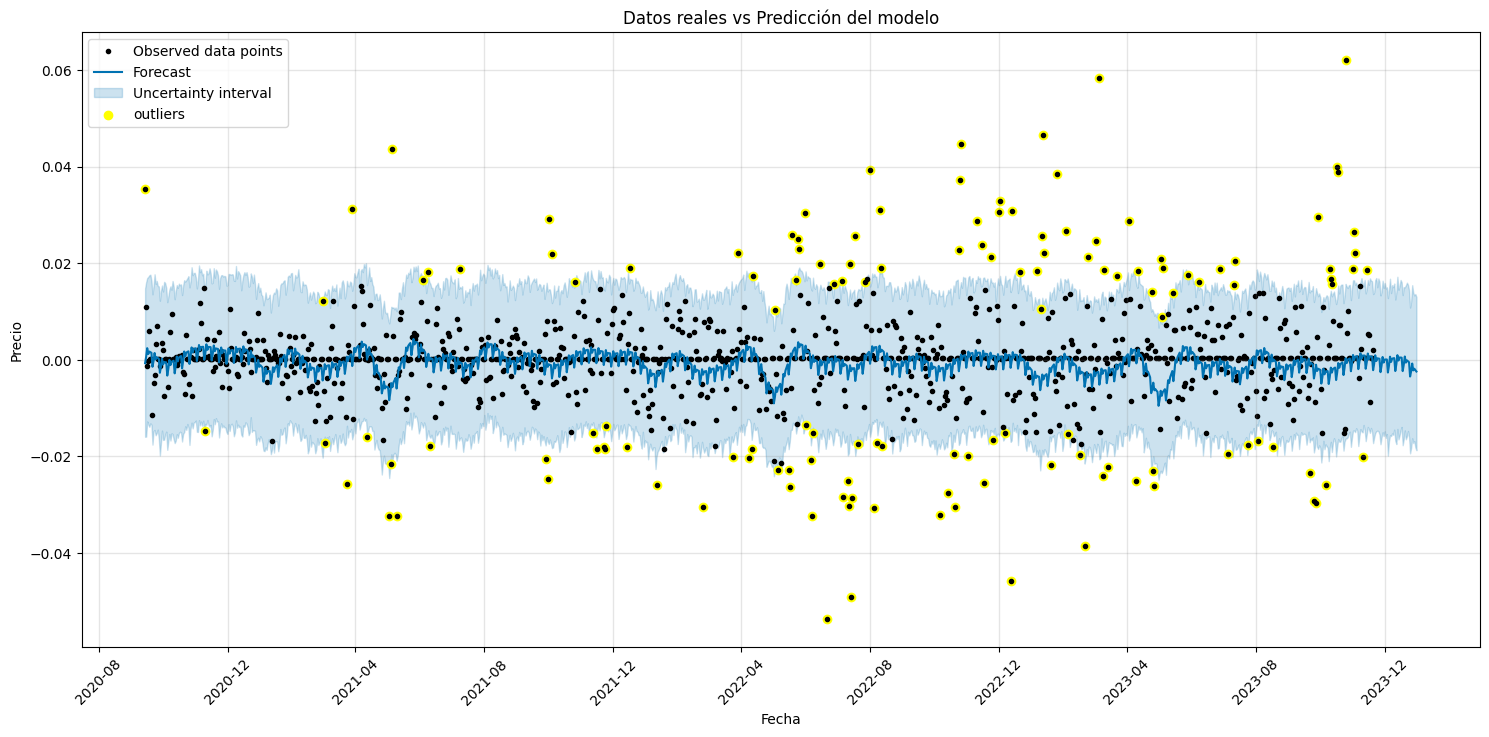

In [69]:
modelo_vs_prediccion_tuning = modelo_cargado_p.plot(forecast,figsize=(15,7))
#modelo_vs_prediccion_tuning.axes[0].get_lines()[1].remove()
#plt.plot(training['ds'], vector_desvest,'-',color='blue')
#plt.plot(training['ds'], vector_desvest2,'-',color='blue')
plt.scatter(outliers['ds'], outliers['y'], color='yellow', label='outliers')
plt.scatter(outliers_pruebas['Fecha'], outliers_pruebas['y'], color='yellow')
plt.scatter(resultado['ds'], resultado['y'], marker = '.',color='black')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.1)
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Datos reales vs Predicción del modelo')
plt.legend()
plt.show()

Se entrena con Isolation Forest

In [ ]:
modelo_deteccion = IsolationForest(n_estimators=100,max_samples='auto',contamination=0.1,random_state=42, max_features=1)
modelo_deteccion.fit(datos['y'].to_numpy().reshape(-1,1))

IsolationForest(contamination=0.1, max_features=1, random_state=42)

In [ ]:
with open('modelo.pkl', 'wb') as modelo_guardado:
    pickle.dump(modelo_deteccion, modelo_guardado)

In [ ]:
modelo_guardado= open('modelo.pkl', 'rb')
modelo_cargado = pickle.load(modelo_guardado)

In [ ]:
modelo_salida = modelo_cargado.predict(datos['y'].to_numpy().reshape(-1,1))

In [ ]:
result_df = pd.DataFrame({'ds':datos['ds'],'y': datos['y'], 'outliers': [1 if x == 1 else -1 for x in modelo_salida]})
result_df.describe()

,y,outliers
count,1163.000000,1163.000000
mean,0.000092,0.798796
std,0.010369,0.601861
min,-0.053723,-1.000000
25%,-0.002989,1.000000
50%,0.000257,1.000000
75%,0.002652,1.000000
max,0.062092,1.000000


In [ ]:
INLIERS = result_df[result_df['outliers']==1]
INLIERS.describe()

,y,outliers
count,1046.000000,1046.0
mean,0.000080,1.0
std,0.005969,0.0
min,-0.016782,1.0
25%,-0.002172,1.0
50%,0.000258,1.0
75%,0.002013,1.0
max,0.018145,1.0


In [ ]:
OUTLIERS = result_df[result_df['outliers']==-1]

OUTLIERS.sort_values(by='ds')
OUTLIERS

,ds,y,outliers
10046,2021-07-09,0.018757,-1
18076,2021-05-03,-0.032427,-1
21270,2023-03-14,-0.022228,-1
52492,2023-09-21,-0.023428,-1
73498,2022-05-09,-0.021302,-1
...,...,...,...
641098,2022-11-02,-0.019841,-1
643874,2023-04-27,-0.026048,-1
643882,2023-01-25,0.038459,-1
652674,2023-03-06,0.058451,-1


In [ ]:
#comparacion 
OUTLIERS = pd.merge(datos[['ds','NEMOTECNICO']], OUTLIERS[['ds','y','outliers']], on = 'ds')
INLIERS = pd.merge(datos[['ds','NEMOTECNICO']],INLIERS[['ds','y','outliers']],on='ds')
alertas = OUTLIERS.append(INLIERS,ignore_index=True)

In [ ]:
alertas.sort_values(by='ds')

,ds,NEMOTECNICO,y,outliers
110,2020-09-14,TFIT31261050,0.035291,-1
1038,2020-09-15,TFIT31261050,0.010831,1
1039,2020-09-16,TFIT31261050,-0.001318,1
652,2020-09-17,TFIT31261050,-0.000296,1
727,2020-09-18,TFIT31261050,0.005971,1
...,...,...,...,...
434,2023-11-16,TFIT31261050,0.005153,1
430,2023-11-17,TFIT31261050,-0.008737,1
942,2023-11-18,TFIT31261050,0.000279,1
437,2023-11-19,TFIT31261050,0.000294,1


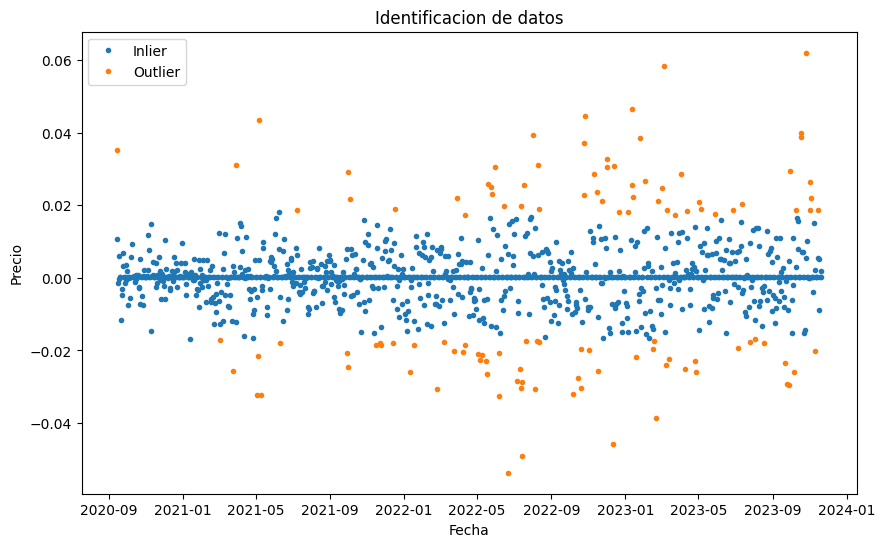

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(INLIERS['ds'], INLIERS[['y']],'.', label='Inlier')
plt.plot(OUTLIERS['ds'], OUTLIERS['y'],'.', label='Outlier')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Identificacion de datos')
plt.legend()
plt.show()

In [40]:
def prediccion_prophet(fecha,valor_unidad,modelo_cargado_p):
    '''Con esta funcion predecimos en prophet si un valor de unidad es atipico o no'''

    datos_consulta = pd.DataFrame([[fecha,valor_unidad]], columns = ['ds', 'y'])
    dato_actual = modelo_cargado_p.predict(pd.DataFrame( [[fecha,valor_unidad]], columns =['ds', 'y']))

    if datos_consulta.loc[0,'y'] < dato_actual.loc[0,'yhat_upper'] and datos_consulta.loc[0,'y'] > dato_actual.loc[0,'yhat_lower'] :
        return 'Normal', dato_actual.loc[0,'yhat_upper'], dato_actual.loc[0,'yhat_lower']
    elif datos_consulta.loc[0,'y']== dato_actual.loc[0,'yhat_upper'] or datos_consulta.loc[0,'y'] == dato_actual.loc[0,'yhat_lower']:
        return 'limite banda confianza'
    else:
        return 'atipico'

prediccion_prophet('2023-12-31'	,-0.002263,modelo_cargado_p)

('Normal', 0.013904465614913597, -0.017179699044222164)

In [ ]:
def prediccion_IsolationForest(fecha, valor_unidad, modelo_cargado):
    '''Con esta funcion predecimos con la ayuda de un IsolationForest si un valor de unidad es atipico o no'''

    datos_consulta = pd.DataFrame([[fecha,valor_unidad]], columns =['ds', 'y'])
    modelo_s = modelo_cargado.predict(datos_consulta['y'].to_numpy().reshape(-1,1))

    if int(modelo_s) == 1:
         print('El dato es aparentemente normal')
    elif int(modelo_s) == -1:
        print('Se deberia revisar el dato ya que parece ser un dato atipico')

prediccion_IsolationForest('2024-12-27', -0.001858, modelo_cargado)

El dato es aparentemente normal


Seleccion de los datos para revision con los marcados en realidad como atipicos

In [ ]:
#comparacion 
filas = pd.merge(outliers[['ds','y']], OUTLIERS[['ds','y']], on = 'ds', how='inner')
filas[['ds','y_y']].describe()

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
outliers.merge(OUTLIERS,how='outer',indicator='union')


Se visualiza que todos los valores detectados como atipicos por prophet estan en el IsolationForest a excepcion de una fecha 2022-12-07

In [ ]:
%pip install sqlalchemy==1.4.46

In [ ]:
%pip install sqlalchemy-databricks

In [68]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)
#alertas.to_sql(name='Valores_unidad_marcados', con = engine)
bandas.to_sql(name='Predicciones', con = engine)

In [ ]:
%pip install pandas-gbq

In [55]:
def prediccion_prophet(fecha,NEMOTECNICO,modelo_cargado_p):
    '''Con esta funcion predecimos en prophet si un valor de unidad es atipico o no'''

    datos_consulta = pd.DataFrame([[fecha]], columns = ['ds'])
    dato_actual = modelo_cargado_p.predict(pd.DataFrame( [[fecha]], columns =['ds']))

    return pd.DataFrame([[fecha, NEMOTECNICO, dato_actual.loc[0,'yhat_upper'], dato_actual.loc[0,'yhat_lower']]], columns = ['Fecha','NEMOTECNICO','limite_superior', 'limite_inferior'])


In [42]:
prediccion_prophet('2020-09-18','TFIT31261050',modelo_cargado_p)

,Fecha,NEMOTECNICO,limite_superior,limite_inferior
0,2020-09-18,TFIT31261050,0.017627,-0.01499


In [128]:
fecha = (date.today()+timedelta(1)).strftime("%Y-%m-%d")

In [130]:
nueva_fila = prediccion_prophet(fecha,'TFIT31261050',modelo_cargado_p)
nueva_fila.to_sql(name='VALUE', con = engine)

In [133]:
import pandas_gbq
def send_data(nueva_fila):
   load_dotenv()
   DESTINATION_PROJECT = os.getenv('DESTINATION_PROJECT')
   DESTINATION_DATASET = os.getenv('DESTINATION_DATASET')
   table_id = f"{DESTINATION_DATASET}.ALERTA_INVERSIONES"
   return nueva_fila.to_gbq(destination_table=table_id, project_id=DESTINATION_PROJECT, if_exists = 'append')


In [134]:
send_data(nueva_fila)

100%|██████████| 1/1 [00:00<00:00, 6657.63it/s]


In [1]:
def final_evaluation(data):
    datos = rename(data)
    datos_copy = datos.copy()
    datos_copy.sort_values(by='ds')
    datos_copy['ds'] = pd.to_datetime(datos_copy['ds'], dayfirst=True)
    training = datos_copy.loc[datos_copy['ds'] < '2023-01-01']
    test = datos_copy.loc[datos_copy['ds'] >= '2023-01-01']
    test = test.loc[test['ds'] < '2023-11-21']
    modelo = Prophet(interval_width=0.90)
    modelo.fit(training)

    future = modelo.make_future_dataframe(periods = 365)

    forecast = modelo.predict(future)
    forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    sns.lineplot(x='ds', y='y', data= datos_copy)
    plt.legend(datos_copy['NEMOTECNICO'].iloc[:])
    return forecast, plt.show()
    

In [18]:
def historico(datos):
    '''Esta funcion nos permiten visualizar el historico de los datos'''
    datos['FECHA_VALORACION'] = pd.to_datetime(datos['FECHA_VALORACION'], dayfirst=True)
    sns.lineplot(x='FECHA_VALORACION', y='f0_', data = datos)
    plt.legend(datos['NEMOTECNICO'].iloc[:])
    return plt.show()

In [9]:
from statsmodels.tsa.stattools import adfuller

In [16]:
lista = []
for i in original_data:
    try:
        dt=original_data[i]
        dt['FECHA_VALORACION']= pd.to_datetime(dt['FECHA_VALORACION'], dayfirst=True)
        resultado_adf = adfuller(dt['f0_'])
        if resultado_adf[1] > 0.05: 
            lista.append(i)
            print('Estadística de la prueba:', resultado_adf[0])
            print('Valor p:', resultado_adf[1])
            print('Valores críticos:', resultado_adf[4])
        else:
            pass
    except ValueError:
        pass

Estadística de la prueba: -1.7322516668602381
Valor p: 0.4145767065838161
Valores críticos: {'1%': -10.41719074074074, '5%': -5.77838074074074, '10%': -3.391681111111111}
Estadística de la prueba: -1.654733227951939
Valor p: 0.4545730899699137
Valores críticos: {'1%': -10.41719074074074, '5%': -5.77838074074074, '10%': -3.391681111111111}
Estadística de la prueba: -1.6032600223886926
Valor p: 0.48195565936592133
Valores críticos: {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487}
Estadística de la prueba: -1.3687825560421576
Valor p: 0.5971473159785949
Valores críticos: {'1%': -3.7883858816542486, '5%': -3.013097747543462, '10%': -2.6463967573696143}
Estadística de la prueba: 0.6825284740931152
Valor p: 0.9894826676344453
Valores críticos: {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}
Estadística de la prueba: 0.2164159192734833
Valor p: 0.9731674283039703
Valores críticos: {'1%': -4.223238279489106, '5%': -3.189368925619835, '10%': -2.729839421487603

In [17]:
lista

['BBSA5189C4',
 'BCTE119SA005',
 'BECO01109A7',
 'BSBCX323SB36',
 'BWWB117SA2',
 'CDTBSA90P',
 'DHCELSIA',
 'INST10210921',
 'INST10220621',
 'TCO364080322',
 'TIPN16A27',
 'TIPU4A29',
 'US912828ZF00']

In [ ]:
count = 0
for i in original_data:
    try:
        count += 1
        dt=original_data[i]
        print(final_evaluation(dt))
    except ValueError:
        pass
